# To - do list:
List danh sách đã làm được trong phần code:
1. Đã xử lý được text + hình ảnh rồi kết hợp với mô hình clip bằng tiếng việt
2. Đã có giao diện bao gồm cho phép nhập text, tải ảnh (cho phép người dùng upload tối đa 2 ảnh)
3. Sử dụng được vector db ( áp dụng pinecone) và đang nghiên cứu sqlite và  postgresql
4. Đã có t-sne plot

List chưa làm được và cần cải thiện trong tương lai:
1. Chưa tăng được accuracy của mô hình (dự định: sử dụng hdf5 để lưu ảnh hoặc sử dụng transfer learning để train thêm data)
2. Khi người dùng upload 2 ảnh cùng một lúc, chưa thể plot ra được những hình ảnh liên quan (dự định: dùng moco hoặc contrastive multiview coding)


# Library using and downloading

## download

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install ftfy regex tqdm -q
!pip install git+https://github.com/openai/CLIP.git -q
!pip install gradio -q
!pip install deep-translator -q
!pip install openTSNE -q
!pip3 install tsnecuda==3.0.1+cu122 -f https://tsnecuda.isx.ai/tsnecuda_stable.html -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.6/436.6 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━

## Import libraries

In [ ]:
import torch
import pickle
import os
import io
import numpy as np
from deep_translator import GoogleTranslator
from sklearn.metrics.pairwise import cosine_similarity
import clip
import gradio as gr
from PIL import Image
import zipfile
from tqdm import tqdm
import matplotlib.pyplot as plt
import csv
import pandas as pd
import plotly.express as px

from torch.amp import autocast
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans

import tsnecuda
from sklearn.decomposition import PCA

# Upload dataset from Kaggle

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = "nguynctr"  # Replace with your Kaggle username
os.environ['KAGGLE_KEY'] = "4880f09584aba650809a3f31e48a9793"  # Replace with your Kaggle API key

!kaggle datasets download -d adityajn105/flickr30k
!unzip /content/flickr30k.zip

# Training Data (optional)

In [ ]:
# import pickle
# from torchvision import transforms

# # Path to the subfolder containing images
# image_subdir = "/content/Images/flickr30k_images" # Có 1 cái folder phụ phía trong(ảnh trùng lặp như folder chính)
# captions_file = "/content/captions.txt"
# processed_data_file = "/content/processed_data_with_augmentation.pkl" #file to store process data

# # Parse captions to get descriptions for each image
# descriptions = {}
# with open(captions_file, 'r') as file:
#     for line in file.readlines():
#         line = line.strip()
#         if ',' in line:
#             image_id, caption = line.split(',', 1)
#             if image_id not in descriptions:
#                descriptions[image_id] = []
#             descriptions[image_id].append(caption)
#         else:
#            print(f"Warning: Skipping line with unexpected format: {line}")

# # Load CLIP model and preprocessing module
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/32", device=device)

# # Augment data to increase accuracy
# augmentation_transforms = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(degrees=15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
# ])

# # Preprocess and encode all images, including augmented versions
# image_embeddings = []
# image_filenames = []

# for image_file in descriptions:
#     # Directly search in the flickr30k_images subfolder
#     image_path = os.path.join(image_subdir, image_file)

#     # Skip the image if it is not found
#     if not os.path.exists(image_path):
#         continue

#     # Load and preprocess the image
#     image = Image.open(image_path)
#     image_tensor = preprocess(image).unsqueeze(0).to(device)

#     # Encode the original image
#     with torch.no_grad():
#         image_features = model.encode_image(image_tensor)

#     image_embeddings.append(image_features.cpu().numpy())
#     image_filenames.append(image_file)

#     # Apply augmentations and encode the augmented images
#     for i in range(3):  # Apply augmentation 3 times per image
#         augmented_image = augmentation_transforms(image)
#         augmented_image_tensor = preprocess(augmented_image).unsqueeze(0).to(device)

#         with torch.no_grad():
#             augmented_image_features = model.encode_image(augmented_image_tensor)

#         # Store augmented image embedding with a unique identifier
#         image_embeddings.append(augmented_image_features.cpu().numpy())
#         image_filenames.append(f"{image_file}_aug_{i+1}")

# # Stack image embeddings into a single numpy array
# image_embeddings = np.vstack(image_embeddings)

# # Save the processed and augmented data
# with open(processed_data_file, 'wb') as f:
#     pickle.dump((image_embeddings, image_filenames), f)

# print(f"Processed and augmented data saved to {processed_data_file}.")

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 108MiB/s]


KeyboardInterrupt: 

# Visualize t-SNE

## Reading Data

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)
model.to(device)

captions_file = "/content/captions.txt"
image_to_caption = {}

with open(captions_file, 'r', newline='') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        if row:
            image_name, caption = row[0].strip(), row[1].strip()
            if image_name in image_to_caption:
                image_to_caption[image_name].append(caption)
            else:
                image_to_caption[image_name] = [caption]

In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, image_folder, image_to_caption, preprocess):
        self.image_folder = image_folder
        self.image_to_caption = image_to_caption
        self.preprocess = preprocess
        self.image_names = list(image_to_caption.keys())

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_folder, image_name)
        caption = self.image_to_caption[image_name][0][:512]

        truncated_caption = caption[:76]  # 76 characters to leave room for end-of-text token

        image = self.preprocess(Image.open(image_path))

        return image_name, image, truncated_caption

image_folder = "/content/Images"
batch_size = 16

dataset = FlickrDataset(image_folder, image_to_caption, preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

image_embeddings = []
text_embeddings = []

for image_names, images, captions in tqdm(dataloader, desc="Processing Batches", leave=False):
    images = images.to(device)

    text_tokens = clip.tokenize(captions).to(device)

    with torch.no_grad():
        with autocast('cuda'):  # Mixed precision for faster processing
            # Check if model is in DataParallel mode and handle accordingly
            if isinstance(model, torch.nn.DataParallel):
                image_features = model.module.encode_image(images)
                text_features = model.module.encode_text(text_tokens)
            else:
                image_features = model.encode_image(images)
                text_features = model.encode_text(text_tokens)

    image_embeddings.append(image_features.cpu().numpy())
    text_embeddings.append(text_features.cpu().numpy())

In [ ]:
image_embeddings = np.vstack(image_embeddings)
text_embeddings = np.vstack(text_embeddings)
combined_embeddings = np.vstack((image_embeddings, text_embeddings))
print('done combining embeddings')

### Pre-clustering

In [ ]:
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
clusters = kmeans.fit_predict(combined_embeddings)

### Without PCA (no pre-clustering)

In [ ]:
try:
    tsne_results = tsnecuda.TSNE(n_components=2, perplexity=30, learning_rate=200).fit_transform(combined_embeddings)
    print('done tsne')
except Exception as e:
    print("Failed to complete t-SNE:", e)
    raise

labels = ['Image'] * len(image_embeddings) + ['Text'] * len(text_embeddings)

df = pd.DataFrame({
    't-SNE Component 1': tsne_results[:, 0],
    't-SNE Component 2': tsne_results[:, 1],
    'Label': labels
})

fig = px.scatter(
    df,
    x='t-SNE Component 1',
    y='t-SNE Component 2',
    color='Label',
    color_discrete_map={"Image": "blue", "Text": "green"},
    labels={"Label": "Type"},
    title='Interactive t-SNE Visualization of Flickr30k Image and Text Embeddings',
    width=800,
    height=600,
    opacity=0.5
)

fig.update_traces(marker=dict(size=5))

fig.update_layout(
    legend_title_text='Type',
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2"
)

fig.show()

### Without PCA (Pre-clutering)

In [ ]:
df = pd.DataFrame({
    't-SNE Component 1': tsne_results[:, 0],
    't-SNE Component 2': tsne_results[:, 1],
    'Cluster': clusters
})

fig = px.scatter(
    df,
    x='t-SNE Component 1',
    y='t-SNE Component 2',
    color='Cluster',
    color_continuous_scale=px.colors.qualitative.T10,
    labels={'Cluster': 'Cluster'},
    title='Interactive t-SNE Visualization with Pre-clustering of Flickr30k Embeddings',
    width=800,
    height=600,
    opacity=0.6
)

fig.update_layout(
    coloraxis_colorbar=dict(
        title='Cluster',
        tickvals=list(range(min(clusters), max(clusters) + 1)),
        ticktext=['Cluster %d' % i for i in range(min(clusters), max(clusters) + 1)]
    ),
    legend_title_text='Cluster'
)

fig.show()

### With PCA (No pre-clustering)

In [ ]:
pca = PCA(n_components=50)
pca_results = pca.fit_transform(combined_embeddings)
print('done PCA')

In [ ]:
pca_clusters = kmeans.fit_predict(pca_results)

In [ ]:
try:
    tsne_results = tsnecuda.TSNE(n_components=2, perplexity=30, learning_rate=200).fit_transform(pca_results)
    print('done tsne')
except Exception as e:
    print("Failed to complete t-SNE:", e)
    raise

labels = ['Image'] * len(image_embeddings) + ['Text'] * len(text_embeddings)

df = pd.DataFrame({
    't-SNE Component 1': tsne_results[:, 0],
    't-SNE Component 2': tsne_results[:, 1],
    'Label': labels
})

fig = px.scatter(
    df,
    x='t-SNE Component 1',
    y='t-SNE Component 2',
    color='Label',
    color_discrete_map={"Image": "blue", "Text": "green"},
    labels={"Label": "Type"},
    title='Interactive t-SNE Visualization of Flickr30k Image and Text Embeddings',
    width=800,
    height=600,
    opacity=0.5
)

fig.update_traces(marker=dict(size=5))

fig.update_layout(
    legend_title_text='Type',
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2"
)

fig.show()

### Without PCA (Pre-clustering)

In [ ]:
df = pd.DataFrame({
    't-SNE Component 1': tsne_results[:, 0],
    't-SNE Component 2': tsne_results[:, 1],
    'Cluster': pca_clusters
})

fig = px.scatter(
    df,
    x='t-SNE Component 1',
    y='t-SNE Component 2',
    color='Cluster',
    color_continuous_scale=px.colors.qualitative.T10,
    labels={'Cluster': 'Cluster'},
    title='Interactive t-SNE Visualization with Pre-clustering of Flickr30k Embeddings',
    width=800,
    height=600,
    opacity=0.6
)

fig.update_layout(
    coloraxis_colorbar=dict(
        title='Cluster',
        tickvals=list(range(min(clusters), max(clusters) + 1)),
        ticktext=['Cluster %d' % i for i in range(min(clusters), max(clusters) + 1)]
    ),
    legend_title_text='Cluster'
)

fig.show()

# Image and text processing

## try to use deep_translator

In [ ]:
from deep_translator import GoogleTranslator

def encode_text(text):
    # Translate Vietnamese text to English
    translated_text = GoogleTranslator(source='vi', target='en').translate(text)
    print(f"Translated text: {translated_text}")

# Example usage:
encode_text("con chim")


Translated text: bird


# Set up and establish directories and devices

In [ ]:
# Directories and device setup
image_dir = "/content/Images/"
processed_data_file = "/content/processed_data_with_augmentation.pkl"
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
with open(processed_data_file, 'rb') as f:
    image_embeddings, image_filenames = pickle.load(f)
translator = GoogleTranslator(source='vi', target='en')


# Text - to - image function

In [ ]:
# Function to encode text using CLIP model
def encode_text(text):
    translated_text = translator.translate(text)
    text_input = clip.tokenize([translated_text]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    return text_features.cpu().numpy()


In [ ]:
# Function to strip augmentation suffix from filenames (Data xử lí xong bị 1 số lỗi như lặp tên, đổi tên khác so với data ban đầu)
def strip_augmentation_suffix(filename):
    original_filename = filename.split('_aug_')[0]
    if original_filename.endswith(".jpg.jpg"):
        original_filename = original_filename.replace(".jpg.jpg", ".jpg")
    return original_filename

In [ ]:

def image_search(description, similarity_threshold=0.5):
    text_embedding = encode_text(description) # converts the text description into a numerical representation called a "text embedding"
    similarities = cosine_similarity(text_embedding, image_embeddings)
    best_image_paths = []
    seen_filenames = set()

    for idx in range(len(similarities[0])): # calculates the similarity between the text embedding and a set of image embeddings
        similarity = similarities[0][idx]
        if similarity >= similarity_threshold:
            best_image_filename = image_filenames[idx]
            original_filename = strip_augmentation_suffix(best_image_filename)
            if original_filename not in seen_filenames:
                best_image_path = os.path.join(image_dir, original_filename)
                if os.path.exists(best_image_path):
                    best_image_paths.append(best_image_path)
                    seen_filenames.add(original_filename)

    if not best_image_paths:
        best_indices = np.argsort(similarities[0])[::-1][:5]
        for idx in best_indices:
            best_image_filename = image_filenames[idx]
            original_filename = strip_augmentation_suffix(best_image_filename)
            if original_filename not in seen_filenames:
                best_image_path = os.path.join(image_dir, original_filename)
                if os.path.exists(best_image_path):
                    best_image_paths.append(best_image_path)
                    seen_filenames.add(original_filename)

    return best_image_paths

# Image - to - image function (non - vector db)

In [ ]:
# # Image encoding function for image-to-image search
# def encode_image(image_path):
#     image = Image.open(image_path)
#     image_input = preprocess(image).unsqueeze(0).to(device)
#     with torch.no_grad():
#         image_features = model.encode_image(image_input)
#     return image_features.cpu().numpy()


In [ ]:
# # Image-to-image search function
# def image_to_image_search(query_image_path, similarity_threshold=0.7):
#     query_image_embedding = encode_image(query_image_path)
#     similarities = cosine_similarity(query_image_embedding, image_embeddings)
#     best_image_paths = []
#     seen_filenames = set()

#     for idx in np.argsort(similarities[0])[::-1]:
#         similarity = similarities[0][idx]
#         if similarity >= similarity_threshold:
#             best_image_filename = image_filenames[idx]
#             original_filename = strip_augmentation_suffix(best_image_filename)
#             if original_filename not in seen_filenames:
#                 best_image_path = os.path.join(image_dir, original_filename)
#                 if os.path.exists(best_image_path):
#                     best_image_paths.append(best_image_path)
#                     seen_filenames.add(original_filename)

#     if not best_image_paths:
#         best_indices = np.argsort(similarities[0])
#         for idx in best_indices:
#             best_image_filename = image_filenames[idx]
#             original_filename = strip_augmentation_suffix(best_image_filename)
#             if original_filename not in seen_filenames:
#                 best_image_path = os.path.join(image_dir, original_filename)
#                 if os.path.exists(best_image_path):
#                     best_image_paths.append(best_image_path)
#                     seen_filenames.add(original_filename)

#     return best_image_paths

# Image embedding using vector db (pinecone)

## embedding image vector

In [ ]:
import torch
from torchvision import transforms as ts
import torchvision.models as models
import os
import tqdm
import numpy as np
from PIL import Image

class ImageEmbedder:
    def __init__(self):
        # Use GPU if available, otherwise fallback to CPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Normalization for the pretrained SqueezeNet model
        self.normalize = ts.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )

        # Load a pretrained SqueezeNet model
        self.model = models.squeezenet1_0(pretrained=True, progress=False).to(self.device)
        self.model.eval()  # Set the model to evaluation mode

    def embed(self, image_file_name):
        # Open and preprocess the image
        image = Image.open(image_file_name).convert("RGB")
        image = ts.Resize(256)(image)
        image = ts.CenterCrop(224)(image)
        tensor = ts.ToTensor()(image)

        # Normalize and move the tensor to GPU
        tensor = self.normalize(tensor).unsqueeze(0).to(self.device)

        # Get the embedding and detach it from the computation graph
        with torch.no_grad():
            vector = self.model(tensor).cpu().numpy().flatten()

        return vector

# Instantiate the ImageEmbedder
image_embedder = ImageEmbedder()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Function to truncate or pad vectors to 512 dimensions
def adjust_vector_dimension(vector, target_dimension=512):
    if len(vector) > target_dimension:
        return vector[:target_dimension]  # Truncate
    elif len(vector) < target_dimension:
        # Pad with zeros if less than 512
        return np.pad(vector, (0, target_dimension - len(vector)), mode='constant')
    return vector

## add data to pinecone

### data preprocessing

In [ ]:
# root_path = '/content/Images/flickr30k_images'
# image_vectors = []

# # Loop through images and store their embeddings with tqdm progress bar
# for image_path in tqdm(os.listdir(root_path)):
#     image_file_name = os.path.join(root_path, image_path)
#     vector = image_embedder.embed(image_file_name)

#     # Append the image name and its vector as a row
#     image_vectors.append([image_file_name, vector])

# # Create DataFrame where 'Image' column contains file names and 'Vector' column contains embeddings
# df = pd.DataFrame(image_vectors, columns=['Image', 'Vector'])

# # Optionally, save the DataFrame to a CSV file
# df.to_csv('image_vectors.csv', index=False)

# # Display DataFrame
# print(df.head())


### upsert to pinecone

In [ ]:
# if df.empty:
#     print("DataFrame is empty after filtering. Check the data and the fix_array_format_safe function.")
# else:
#     pc = Pinecone(api_key='4c6c3ae7-2ff7-468a-9dc8-f2dee8c019f1')

#     index_name = 'clip-ceh0'
#     if index_name not in pc.list_indexes().names():
#         pc.create_index(
#             name=index_name,
#             dimension=vector_dimension,
#             metric='cosine',
#             spec=ServerlessSpec(
#                 cloud='aws',
#                 region='us-east-1'
#             )
#         )

#     index = pc.Index(index_name)


In [ ]:
# # Function to batch upsert vectors
#     def batch_upsert(index, vectors, batch_size=100):
#         for i in tqdm(range(0, len(vectors), batch_size)):
#             batch = vectors[i:i + batch_size]
#             index.upsert(vectors=batch)
#             print(f"Upserted batch {i // batch_size + 1} with {len(batch)} vectors.")

#     # Upsert vectors to Pinecone in batches
#     if vectors_to_upsert:
#         batch_upsert(index, vectors_to_upsert, batch_size=100)  # Adjust batch size as needed
#         print(f"Total vectors upserted: {len(vectors_to_upsert)} to Pinecone index '{index_name}'.")
#     else:
#         print("No vectors to upsert.")

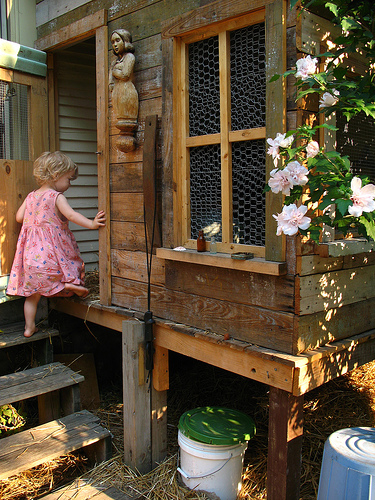

In [ ]:
def get_image(image_name):
    # Construct the full path to the image
    full_image_path = os.path.join(root_path, image_name)

    # Check if the image exists
    if os.path.exists(full_image_path):
        # Open and return the image
        return Image.open(full_image_path)
    else:
        raise FileNotFoundError(f"No image found at {full_image_path}")


get_image("1000268201.jpg")

## connect to pinecone

In [ ]:
!pip install pinecone

In [ ]:
from pinecone import Pinecone

pc = Pinecone(api_key="4c6c3ae7-2ff7-468a-9dc8-f2dee8c019f1")
index = pc.Index("clip-ceh0")

In [ ]:
import gradio as gr

# Define the image processing function
def process_image(image_path,top_k):
    emb = image_embedder.embed(image_path)
    emb_512 = adjust_vector_dimension(emb, 512)
    emb_vec = np.array(emb_512).tolist()
    query_resp = index.query(vector=emb_vec, top_k=top_k)
    return query_resp

# Function to display the top_k images
def image_show(image_path, top_k):
    query_resp = process_image(image_path, top_k)
    image_list = []
    for i in range(top_k):
        imgs = get_image(query_resp.matches[i].id)
        image_list.append(imgs)
    return image_list

# Create Gradio interface
def gradio_interface(image_path, top_k):
    return image_show(image_path, top_k)

# Set up the Gradio app with an image input and a slider for top_k
gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Image(type="filepath"),  # Image input
        gr.Slider(1, 20, step=1, value=10, label="Top K Results")  # Slider for top_k
    ],
    outputs=gr.Gallery(label="Similar Images")  # Gallery to display images
).launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c74f9b43126b8a0f4b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Gradio function

In [ ]:
# Function to dynamically toggle inputs based on search mode and number of images
def toggle_inputs(search_mode, num_images):
    if search_mode == "Text-to-Image":
        return (gr.update(visible=True),  # Show text input
                gr.update(visible=False),  # Hide num_images radio
                gr.update(visible=False),  # Hide image_input_1
                gr.update(visible=False),  # Hide image_input_2
                "", [])  # Clear output
    elif search_mode == "Image-to-Image":
        return (gr.update(visible=False),  # Hide text input
                gr.update(visible=True),   # Show num_images radio
                gr.update(visible=True),    # Show image_input_1
                gr.update(visible=(num_images == "2")),  # Conditionally show image_input_2
                "", [])  # Clear output

# Create the Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## Dynamic Input Toggle with Text-to-Image Search")

    # Search mode selection
    search_mode = gr.Radio(["Text-to-Image", "Image-to-Image"], label="Select Search Mode")

    # Text input for Text-to-Image
    text_input = gr.Textbox(label="Enter text for image generation", visible=False)

    # Number of images selection for Image-to-Image
    num_images = gr.Radio(["1", "2"], label="Number of images", visible=False)

    # Image inputs
    image_input_1 = gr.Image(label="Select first image", type="filepath", visible=False)
    image_input_2 = gr.Image(label="Select second image", type="filepath", visible=False)

    # Output gallery for images
    output_gallery = gr.Gallery(label="Best Matching Images")

    # Button to trigger the image search for Text-to-Image
    search_button = gr.Button("Search")

    # Set up the dynamic input toggle
    search_mode.change(lambda mode: toggle_inputs(mode, num_images.value), search_mode,
                       [text_input, num_images, image_input_1, image_input_2, output_gallery])

    # Update image input visibility based on the number of images
    num_images.change(lambda num: gr.update(visible=(num == "2")), num_images, image_input_2)

    # Connect the search button to the image search function
    search_button.click(image_search, text_input, output_gallery)

# Launch the Gradio interface
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://de59a234b3792633c5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Define the image processing function for Image-to-Image
def process_image(image_path, top_k):
    emb = image_embedder.embed(image_path)
    emb_512 = adjust_vector_dimension(emb, 512)
    emb_vec = np.array(emb_512).tolist()
    query_resp = index.query(vector=emb_vec, top_k=top_k)
    return query_resp

# Function to display the top_k images
def image_show(image_path, top_k):
    query_resp = process_image(image_path, top_k)
    image_list = []
    for i in range(top_k):
        imgs = get_image(query_resp.matches[i].id)
        image_list.append(imgs)
    return image_list

# Function to dynamically toggle inputs based on search mode and number of images
def toggle_inputs(search_mode, num_images):
    if search_mode == "Text-to-Image":
        return (gr.update(visible=True),  # Show text input
                gr.update(visible=False),  # Hide num_images radio
                gr.update(visible=False),  # Hide image_input_1
                gr.update(visible=False),  # Hide image_input_2
                "", [])  # Clear output
    elif search_mode == "Image-to-Image":
        return (gr.update(visible=False),  # Hide text input
                gr.update(visible=True),   # Show num_images radio
                gr.update(visible=True),    # Show image_input_1
                gr.update(visible=(num_images == "2")),  # Conditionally show image_input_2
                "", [])  # Clear output

# Create the Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## Dynamic Input Toggle with Text-to-Image and Image-to-Image Search")

    # Search mode selection
    search_mode = gr.Radio(["Text-to-Image", "Image-to-Image"], label="Select Search Mode")

    # Text input for Text-to-Image
    text_input = gr.Textbox(label="Enter text for image generation", visible=False)

    # Number of images selection for Image-to-Image
    num_images = gr.Radio(["1", "2"], label="Number of images", visible=False)

    # Image inputs
    image_input_1 = gr.Image(label="Select first image", type="filepath", visible=False)
    image_input_2 = gr.Image(label="Select second image", type="filepath", visible=False)

    # Output gallery for images
    output_gallery = gr.Gallery(label="Best Matching Images", show_label=True, elem_id="output-gallery")

    # Button to trigger the image search for Text-to-Image
    search_button_text_to_image = gr.Button("Search (Text-to-Image)")

    # Button to trigger the image search for Image-to-Image
    search_button_image_to_image = gr.Button("Search (Image-to-Image)", visible=False)

    # Set up the dynamic input toggle
    search_mode.change(lambda mode: toggle_inputs(mode, num_images.value), search_mode,
                       [text_input, num_images, image_input_1, image_input_2, output_gallery, search_button_image_to_image])

    # Update image input visibility based on the number of images
    num_images.change(lambda num: gr.update(visible=(num == "2")), num_images, image_input_2)

    # Connect the search button for Text-to-Image to the image search function
    search_button_text_to_image.click(image_search, text_input, output_gallery)

    # Connect the search button for Image-to-Image to the image show function
    search_button_image_to_image.click(image_show, image_input_1, num_images, output_gallery)

# Launch the Gradio interface
demo.launch()

/usr/local/lib/python3.10/dist-packages/gradio/utils.py:980: UserWarning: Expected 2 arguments for function <function image_show at 0x7e6d9afa7d00>, received 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/utils.py:984: UserWarning: Expected at least 2 arguments for function <function image_show at 0x7e6d9afa7d00>, received 1.
  warnings.warn(


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6c628a669861ea3c88.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Function to dynamically toggle inputs based on search mode and number of images
def toggle_inputs(search_mode, num_images):
    if search_mode == "Text-to-Image":
        return (gr.update(visible=True),  # Show text input
                gr.update(visible=False),  # Hide num_images radio
                gr.update(visible=False),  # Hide image_input_1
                gr.update(visible=False),  # Hide image_input_2
                "", [])  # Clear output
    elif search_mode == "Image-to-Image":
        return (gr.update(visible=False),  # Hide text input
                gr.update(visible=True),   # Show num_images radio
                gr.update(visible=True),    # Show image_input_1
                gr.update(visible=True),     # Always show image_input_2
                "", [])  # Clear output

# Create the Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## Dynamic Input Toggle with Text-to-Image and Image-to-Image Search")

    # Search mode selection
    search_mode = gr.Radio(["Text-to-Image", "Image-to-Image"], label="Select Search Mode")

    # Text input for Text-to-Image
    text_input = gr.Textbox(label="Enter text for image generation", visible=False)

    # Number of images selection for Image-to-Image
    num_images = gr.Radio(["1", "2"], label="Number of images", value="1", visible=False)

    # Image inputs
    image_input_1 = gr.Image(label="Select first image", type="filepath", visible=False)
    image_input_2 = gr.Image(label="Select second image", type="filepath", visible=True)  # Always visible

    # Output gallery for images
    output_gallery = gr.Gallery(label="Best Matching Images", show_label=True)

    # Button to trigger the image search for Text-to-Image
    search_button_text_to_image = gr.Button("Search (Text-to-Image)")

    # Button to trigger the image search for Image-to-Image
    search_button_image_to_image = gr.Button("Search (Image-to-Image)", visible=False)

    # Set up the dynamic input toggle
    search_mode.change(lambda mode: toggle_inputs(mode, num_images.value), search_mode,
                       [text_input, num_images, image_input_1, image_input_2, output_gallery, search_button_image_to_image])

    # Update image input visibility based on the number of images
    num_images.change(lambda num: gr.update(visible=(num == "2")), num_images, image_input_2)

    # Connect the search button for Text-to-Image to the image search function
    search_button_text_to_image.click(image_search, text_input, output_gallery)

    # Connect the search button for Image-to-Image to the image show function
    search_button_image_to_image.click(image_show, [image_input_1, image_input_2], num_images, output_gallery)

# Launch the Gradio interface
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://81e707f50793066710.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
